#  FHIR Observation Inference + Visualization
This notebook loads FHIR Observation JSON files, transforms them into model-ready format, runs predictions using a tuned XGBoost model, and visualizes feature importance.

In [1]:
import os
import json
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [10]:
# Path setup
obs_dir = "../data/observations"
model_path = "../src/models/tuned_xgb_fhir.pkl"
feature_order_path = "/mnt/data/cardiorisk_2505/src/models/fhir_feature_order.pkl"

booster = joblib.load(model_path)
feature_order = joblib.load(feature_order_path)


In [11]:
# Read and parse FHIR Observation JSONs
records = []
for fname in os.listdir(obs_dir):
    with open(os.path.join(obs_dir, fname)) as f:
        obs = json.load(f)
        patient_id = obs["subject"]["reference"]
        code = obs["code"]["coding"][0]["code"]
        value = obs["valueQuantity"]["value"]
        records.append({"patient": patient_id, "code": code, "value": value})

df_obs = pd.DataFrame(records)

# Map LOINC codes to model features
loinc_map = {
    "30525-0": "age",
    "8480-6": "sysBP",
    "8462-4": "diaBP",
    "2093-3": "totChol",
    "2345-7": "glucose",
    "8867-4": "heartRate"
}
df_obs["feature"] = df_obs["code"].map(loinc_map)


In [13]:
# Pivot to patient-feature matrix
df_feat = df_obs.pivot(index="patient", columns="feature", values="value").reindex(columns=feature_order)

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(df_feat)

# Predict with tuned model
dmatrix = xgb.DMatrix(X, feature_names=feature_order)
y_pred = booster.predict(dmatrix)

df_feat["predicted_risk"] = y_pred
df_feat.reset_index(inplace=True)
df_feat.to_csv("../output/fhir_inference_results.csv", index=False)
df_feat.head()


feature,patient,age,sysBP,diaBP,totChol,glucose,predicted_risk
0,Patient-1000,39.0,106.0,70.0,195.0,77.0,0.103579
1,Patient-1001,46.0,121.0,81.0,250.0,76.0,0.125071
2,Patient-1002,48.0,127.5,80.0,245.0,70.0,0.135434


<Figure size 800x400 with 0 Axes>

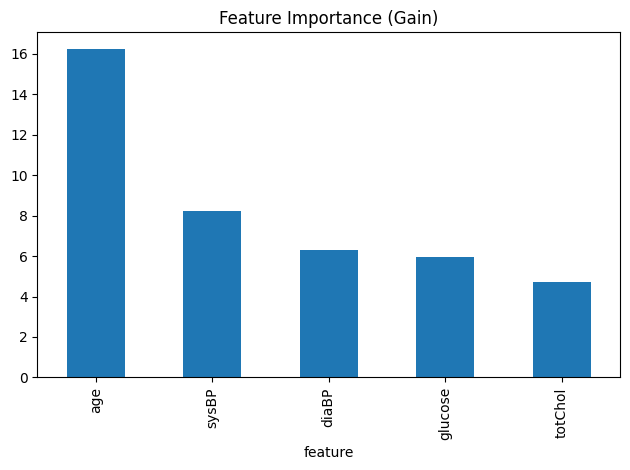

In [14]:
# Fallback visual: Feature Importance by Gain
importances = booster.get_score(importance_type="gain")
imp_df = pd.DataFrame(importances.items(), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(8, 4))
imp_df.set_index("feature").plot.bar(legend=False)
plt.title("Feature Importance (Gain)")
plt.tight_layout()
plt.savefig("../output/feature_importance_fallback.png")
plt.show()
